## FluxInfer RCA from Sock Shop dataset

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict, OrderedDict
import pathlib

import numpy as np
import pandas as pd
import torch
import torchinfo
import scipy.stats
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', FutureWarning)

import sys
sys.path.append("../")

In [3]:
from notebooklib.save import run_tsdr, save_tsdr, load_tsdr

DATASET_ID = "qknmc"
datasets_hdsbcan_sbd = load_tsdr(DATASET_ID, revert_normalized_time_series=True)
datasets_fluxrank_max_cluster = load_tsdr(DATASET_ID, suffix="fluxrank_max_cluster", revert_normalized_time_series=True)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
from itertools import combinations
from typing import Callable

import networkx as nx
from scipy import stats

import diagnoser.metric_node as mn
from diagnoser import diag
from tsdr.outlierdetection.residual_integral import residual_integral_max


def fisher_z(dm, cm, x, y) -> float:
    m = dm.shape[0]
    r = cm[x, y]
    if 1 - r == 0:
        r = 1 - 1e-10
    if r >= 1.0:
        r = 1.0 - 1e-10
    elif r <= -1.0:
        r = -1.0 + 1e-10
    z = np.log((1 + r) / (1 - r))
    zstat = np.sqrt(m - 3) * 0.5 * np.abs(z)
    p_val = 2.0 * scipy.stats.norm.cdf(np.abs(zstat))
    return p_val

# no gsq
def g_sq(dm: np.ndarray, cm: np.ndarray, x: int, y: int) -> float:
    obs = dm[[x, y]]
    np.place(obs, obs == 0.0, 1e-30)
    chi, p_value, dof, expected = stats.chi2_contingency(
        obs, lambda_="log-likelihood",
    )
    return p_value

def build_wudg(pk, data_df: pd.DataFrame, init_graph_type="complete", citest="fisher-z") -> nx.Graph:
    nodes = mn.MetricNodes.from_dataframe(data_df)
    g: nx.Graph
    match init_graph_type:
        case "complete":
            g = nx.Graph()
            for (u, v) in combinations(nodes, 2):
                g.add_edge(u, v)
        case "nw_call":
            g = diag.prepare_init_graph(nodes, pk)
        case _:
            assert False, f"Unknown init_graph_type: {init_graph_type}"
    
    citest_func: Callable
    match citest:
        case "fisher-z":
            dm = data_df.to_numpy(dtype=np.float32)
            cm = np.corrcoef(dm.T)
            citest_func = fisher_z 
        case "gsq":
            dm = data_df.to_numpy(dtype=np.float32).T
            cm = np.array([])
            citest_func = g_sq
        case _:
            raise ValueError(f"Unknown citest: {citest}")

    _g = nx.relabel_nodes(g, mapping=nodes.node_to_num)
    for (u, v) in _g.edges:
        p_val = citest_func(dm, cm, u, v)
        _g[u][v]['weight'] = 1 / p_val if p_val != 0.0 else sys.float_info.max

    return nx.relabel_nodes(_g, mapping=nodes.num_to_node)


def build_wudg_and_pagerank(
    record,
    reduced_df,
    init_graph_type="nw_call",
    citest="fisher-z",
    directed_edge: bool = False,
    personalized: bool = False,
):
    reduced_df = reduced_df.where(reduced_df >= 0.0, 0.0)
    try:
        wudg: nx.Graph = build_wudg(record.pk, reduced_df, init_graph_type=init_graph_type, citest=citest)
    except ValueError as e:
        print(e)
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            print(reduced_df.loc[:, reduced_df.apply(lambda x: np.any((x.to_numpy() < 0.0)), axis=0)])
        return []
    if directed_edge:
        wudg = diag.fix_edge_directions_in_causal_graph(wudg, pk)
    pr: dict
    if personalized:
        personalization = {node: residual_integral_max(reduced_df[str(node)].values, bkp=0)[0] for node in wudg.nodes} 
        pr = nx.pagerank(wudg, alpha=0.85, personalization=personalization)
    else:
        pr = nx.pagerank(wudg, alpha=0.85)
    _records = []
    for metric_name, rank in pr.items():
        _records.append((DATASET_ID, record.target_app(), record.chaos_type(), record.chaos_comp(), str(metric_name), record.data_df[str(metric_name)].values, rank))
    return _records


from itertools import chain

from pandas.core.groupby import DataFrameGroupBy

from eval.groundtruth import check_cause_metrics
from diagnoser.metric_node import MetricNodes
from meltria.priorknowledge.priorknowledge import SockShopKnowledge

from meltria.priorknowledge.priorknowledge import SockShopKnowledge
from diagnoser.metric_node import MetricNodes, MetricNode

pk = SockShopKnowledge(
    target_metric_types={
        "containers": True,
        "services": True,
        "middlewalres": True,
        "nodes": False,
    },
    mappings={"nodes-containers": {}},
)

def get_ranks_by_case(sorted_results_df: DataFrameGroupBy, pk: SockShopKnowledge, granularity: str = "metric"):
    ranks_by_case: dict[str, dict[str, list[int]]] = defaultdict(lambda: defaultdict(list))
    n_cases: int = 0
    for (dataset_id, target_app, chaos_type, chaos_comp), group in sorted_results_df:
        if chaos_comp == "queue-master":
            continue
        metrics = [str(m) for m in group["metric"].values.tolist()]
        ranks: list[int]
        match granularity:
            case "metric":
                ok, cause_metrics = check_cause_metrics(
                    pk, metrics, chaos_type=chaos_type, chaos_comp=chaos_comp, optional_cause=True,
                )
                if not ok or len(cause_metrics) == 0:
                    print(f"no cause metrics: {dataset_id}, {target_app}, {chaos_type}, {chaos_comp}")
                    continue
                metrics = [m for m in metrics if not m.startswith("s-")] # Exclude service metrics
                ranked_metrics = MetricNodes.from_metric_names(metrics)
                ranks = sorted([list(ranked_metrics).index(cm) + 1 for cm in cause_metrics])
            case "container":
                metrics = [m for m in metrics if not m.startswith("s-")] # Exclude service metrics
                ranked_ctnrs = dict.fromkeys([pk.get_container_by_metric(metric) for metric in metrics])
                ranks = sorted([i+1 for i, ctnr in enumerate(ranked_ctnrs) if ctnr == chaos_comp])
            case "service":
                chaos_service: str = pk.get_service_by_container(chaos_comp)
                ranked_service = dict.fromkeys([pk.get_service_by_metric(metric) for metric in metrics])
                ranked_service = [s for s in ranked_service if s is not None and not s.startswith("gke-")]
                ranks = sorted([i+1 for i, service in enumerate(ranked_service) if service == chaos_service])
            case _:
                assert False, f"Unknown detect_unit: {granularity}"
        ranks_by_case[chaos_type][chaos_comp] = ranks
        n_cases += 1
    return ranks_by_case, n_cases


def calc_ac_k(k: int, ranks_by_case: dict[str, dict[str, list[int]]], n_faults: int) -> float:
    ac_a: list[float] = []
    sum_ac = 0.0
    for chaos_type, ranks_by_ in ranks_by_case.items():
        for chaos_comp, ranks in ranks_by_.items():
            if (min_param := min(k, len(ranks)) > 0):
                sum_ac += sum([1 if ranks[i-1] <= k else 0 for i in range(1, min_param+1)]) / min_param
    return sum_ac / n_faults


def evaluate_ac_of_rc(
    sorted_results_df: DataFrameGroupBy, pk: SockShopKnowledge, k: int = 10, granuallity: str = "metric",
) -> pd.DataFrame:
    top_k_set = range(1, k+1)
    ranks_by_case, n_cases = get_ranks_by_case(sorted_results_df, pk, granularity=granuallity)
    ac_k = {k: calc_ac_k(k, ranks_by_case, n_cases) for k in top_k_set}
    avg_k = {k: sum([ac_k[j] for j in range(1, k+1)]) / k for k in top_k_set}
    return pd.concat([pd.DataFrame(ac_k, index=[f"AC@K ({granuallity})"]).T, pd.DataFrame(avg_k, index=[f"AVG@K ({granuallity})"]).T], axis=1)

In [5]:
import joblib

_list_of_records = joblib.Parallel(n_jobs=-1)(joblib.delayed(build_wudg_and_pagerank)(record, reduced_df, init_graph_type="nw_call", citest="fisher-z", directed_edge=False) for record, _, anomalous_df, reduced_df in datasets_fluxrank_max_cluster)
ranked_datasets = sum(_list_of_records, [])  # flatten

ranked_df_max_cluster = pd.DataFrame(ranked_datasets, columns=["dataset_id", "target_app", "chaos_type", "chaos_comp", "metric", "time_series", "rank"])
sorted_results_df = ranked_df_max_cluster.query("not metric.str.startswith('n-')", engine='python').loc[:, ranked_df_max_cluster.columns != "time_series"].dropna(subset=["rank"]).sort_values(["dataset_id", "target_app", "chaos_type", "chaos_comp", "rank"], ascending=False).groupby(["dataset_id", "target_app", "chaos_type", "chaos_comp"])
with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None):
    display(sorted_results_df.head(n=10).set_index(["dataset_id", "target_app", "chaos_type", "chaos_comp"]))

metric  \
dataset_id target_app chaos_type       chaos_comp                                                                                   
qknmc      sock-shop  pod-network-loss user-db                                                                 s-front-end_errors   
                                       user-db                                                                s-orders_throughput   
                                       user-db                                                                   s-orders_latency   
                                       user-db                                                     c-orders_cpu_cfs_periods_total   
                                       user-db                                                  c-orders_cpu_system_seconds_total   
                                       user-db                                                   c-orders_cpu_usage_seconds_total   
                                       user-db                                                    c-orders_cpu_user_seconds_total   
                                       user-db                                  m-orders_java_lang_OperatingSystem_ProcessCpuLoad   
                                       user-db                                  m-orders_java_lang_OperatingSystem_ProcessCpuTime   
                                       user-db                                                       m-orders_jvm_threads_current   
                                       user                                                                s-front-end_throughput   
                                       user                                                                      s-orders_latency   
                                       user                                                                   s-orders_throughput   
                                       user                                                                       c-carts_threads   
                                       user                                                                     s-user_throughput   
                                       user                                                                        s-user_latency   
                                       user                                                                        c-user_sockets   
                                       user                                                                     c-user_memory_rss   
                                       user                                                             c-user_memory_usage_bytes   
                                       user                                                       c-user_memory_working_set_bytes   
                                       payment                                          c-payment_cpu_cfs_throttled_periods_total   
                                       payment                                          c-payment_cpu_cfs_throttled_seconds_total   
                                       payment                                                                    s-carts_latency   
                                       payment                                                                 s-carts_throughput   
                                       payment                                                                 c-carts_memory_rss   
                                       payment                                                         c-carts_memory_usage_bytes   
                                       payment                                                   c-carts_memory_working_set_bytes   
                                       payment                                    m-carts_java_lang_OperatingSystem_SystemCpuLoad   
                                       payment                           m-carts_java_lang_OperatingSystem_FreePhysicalMemorySize   


In [6]:
with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None, "display.precision", 2):
    display(
        pd.concat([
            evaluate_ac_of_rc(sorted_results_df, pk, k=10, granuallity="metric"),
            evaluate_ac_of_rc(sorted_results_df, pk, k=10, granuallity="container"),
            evaluate_ac_of_rc(sorted_results_df, pk, k=10, granuallity="service"),
        ], axis=1)
    )

no cause metrics: qknmc, sock-shop, pod-memory-hog, catalogue
no cause metrics: qknmc, sock-shop, pod-memory-hog, orders
no cause metrics: qknmc, sock-shop, pod-memory-hog, payment
no cause metrics: qknmc, sock-shop, pod-network-loss, catalogue
no cause metrics: qknmc, sock-shop, pod-network-loss, payment
no cause metrics: qknmc, sock-shop, pod-network-loss, user-db


AC@K (metric)  AVG@K (metric)  AC@K (container)  AVG@K (container)  \
1            0.00            0.00              0.14               0.14   
2            0.13            0.07              0.45               0.29   
3            0.17            0.10              0.55               0.38   
4            0.17            0.12              0.76               0.47   
5            0.22            0.14              0.76               0.53   
6            0.26            0.16              0.79               0.57   
7            0.30            0.18              0.86               0.62   
8            0.35            0.20              0.97               0.66   
9            0.39            0.22              0.97               0.69   
10           0.39            0.24              1.00               0.72   

    AC@K (service)  AVG@K (service)  
1             0.24             0.24  
2             0.34             0.29  
3             0.66             0.41  
4             0.83             0.52  
5             0.93             0.60  
6             0.97             0.66  
7             1.00             0.71  
8             1.00             0.75  
9             1.00             0.77  
10            1.00             0.80

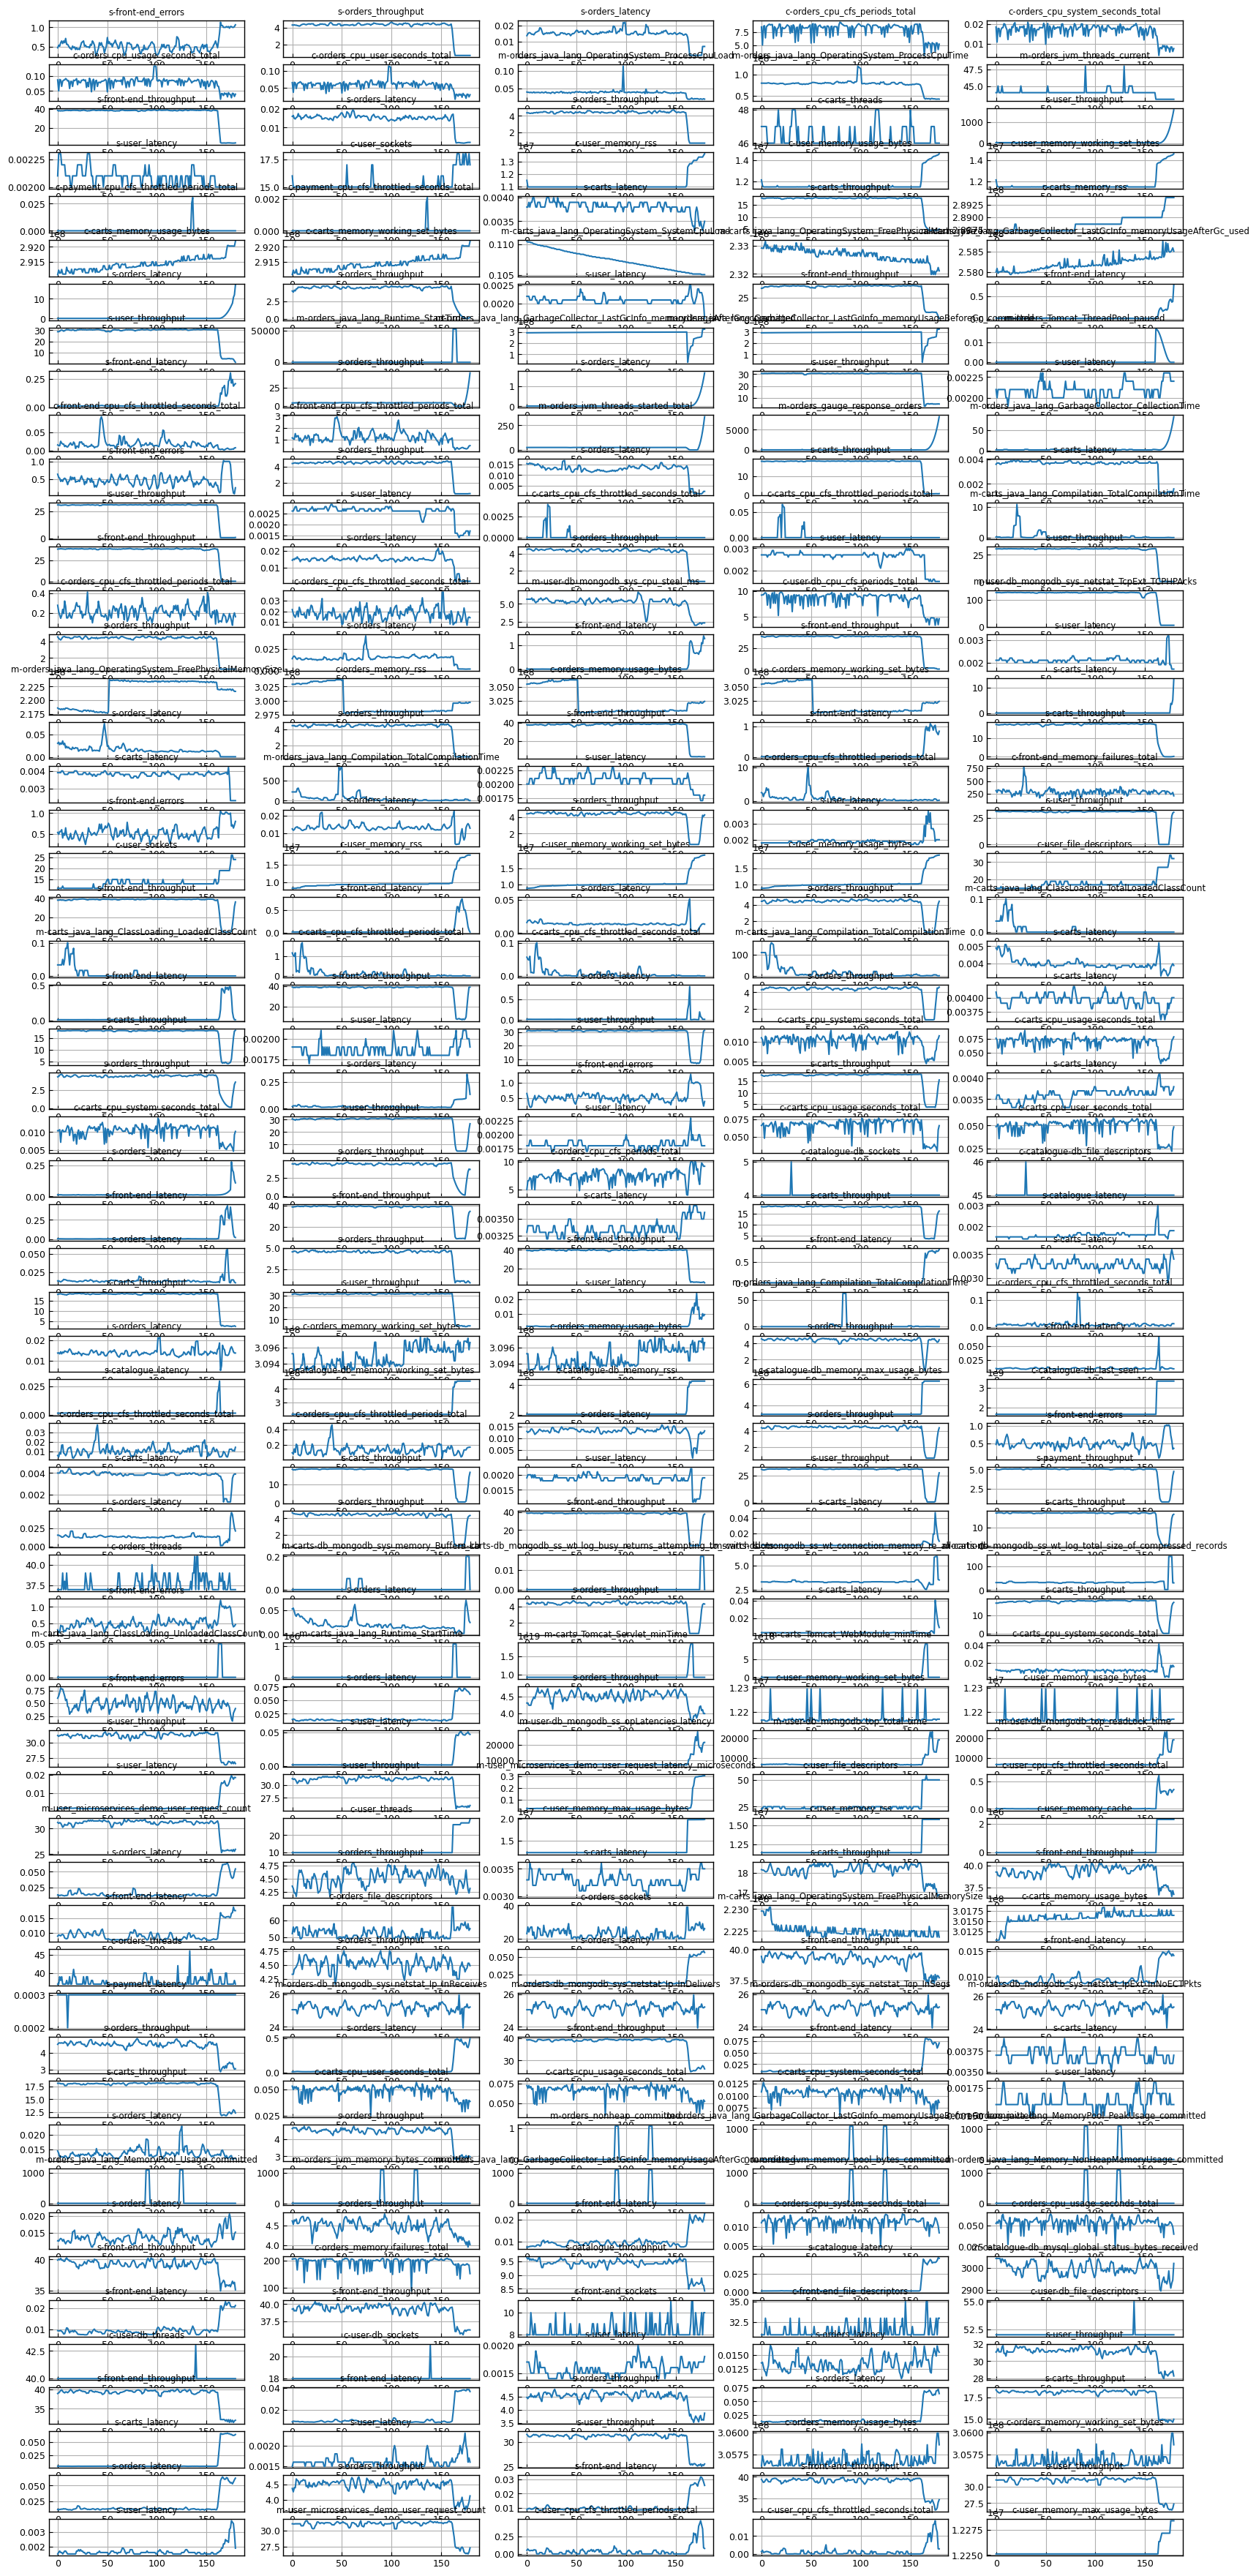

In [7]:
import math

_sorted_results_df = ranked_df_max_cluster.query("not metric.str.startswith('n-')", engine='python').sort_values(["dataset_id", "target_app", "chaos_type", "chaos_comp", "rank"], ascending=False).groupby(["dataset_id", "target_app", "chaos_type", "chaos_comp"]).head(n=10).set_index(["dataset_id", "target_app", "chaos_type", "chaos_comp"])

fig = plt.figure(figsize=(20, 45))
axs = fig.subplots(nrows=math.ceil(_sorted_results_df.shape[0] / 5), ncols=5)
for ax, row in zip(axs.flatten(), _sorted_results_df.itertuples()):
    ax.plot(row.time_series)
    ax.set_title(row.metric)

## 3-Phase reduction

In [8]:
from tsdr import tsdr

def _hier_clustering(pk, data_df: pd.DataFrame, dist_type="sbd"):
    _, clustering_info = tsdr.Tsdr("residual_integral", **{
        "step2_clustering_method_name": "hierarchy",
        "step2_hierarchy_dist_threshold": 0.02,  # should be <1.0 if 'sbd' is specified
        "step2_hierarchy_dist_type": dist_type,  # 'pearsonr' or 'sbd'
        "step2_hierarchy_linkage_method": "single",  # 'single','complete','average','weighted', 'centroid', 'median', 'ward'
        "step2_clustering_series_type": "raw",  # 'raw', 'anomaly_score' or 'binary_anomaly_score'
        "step2_clustering_choice_method": 'medoid',  # 'medoid' or 'maxsum'
    }).reduce_multivariate_series(data_df.apply(scipy.stats.zscore), pk, n_workers=1)
    return data_df[list(clustering_info.keys())]

def _hdbscan_clustering(pk, data_df: pd.DataFrame, dist_type="sbd"):
    _, clustering_info = tsdr.Tsdr("residual_integral", **{
        "step2_clustering_method_name": "dbscan",
        "step2_dbscan_min_pts": 1,
        "step2_dbscan_dist_type": dist_type,  # 'pearsonr' or 'sbd'
        "step2_dbscan_algorithm": "hdbscan",  # 'dbscan' or 'hdbscan'
        "step2_clustering_series_type": "raw",  # 'raw', 'anomaly_score' or 'binary_anomaly_score'
        "step2_clustering_choice_method": 'medoid',  # 'medoid' or 'maxsum'
    }).reduce_multivariate_series(data_df.apply(scipy.stats.zscore), pk, n_workers=1)
    return data_df[list(clustering_info.keys())]

In [9]:
datasets_fluxrank_max_cluster_with_3phase = []
for record, filtered_df, anomalous_df, reduced_df in datasets_fluxrank_max_cluster:
    _df = _hier_clustering(record.pk, reduced_df)
    datasets_fluxrank_max_cluster_with_3phase.append((record, filtered_df, anomalous_df, reduced_df, _df))

In [10]:
_list_of_records = joblib.Parallel(n_jobs=-1)(joblib.delayed(build_wudg_and_pagerank)(record, reduced_df, init_graph_type="nw_call") for record, _, _, _, reduced_df in datasets_fluxrank_max_cluster_with_3phase)
ranked_datasets_with_3phase = sum(_list_of_records, [])  # flatten

In [11]:
ranked_df = pd.DataFrame(ranked_datasets_with_3phase, columns=["dataset_id", "target_app", "chaos_type", "chaos_comp", "metric", "time_series", "rank"])
sorted_results_df_with_3phase = ranked_df.query("not metric.str.startswith('n-')", engine='python').loc[:, ranked_df.columns != "time_series"].dropna(subset=["rank"]).sort_values(["dataset_id", "target_app", "chaos_type", "chaos_comp", "rank"], ascending=False).groupby(["dataset_id", "target_app", "chaos_type", "chaos_comp"])
with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None):
    display(sorted_results_df_with_3phase.head(n=10).set_index(["dataset_id", "target_app", "chaos_type", "chaos_comp"]))

metric  \
dataset_id target_app chaos_type       chaos_comp                                                                                                          
qknmc      sock-shop  pod-network-loss user-db                                                                                       s-orders_throughput   
                                       user-db                                                                                          s-orders_latency   
                                       user-db                                                                              m-orders_jvm_threads_current   
                                       user-db                                                                         c-orders_cpu_system_seconds_total   
                                       user-db                                                                            c-orders_cpu_cfs_periods_total   
                                       user-db                                                                                          m-orders_threads   
                                       user-db                                                                           c-orders_cpu_user_seconds_total   
                                       user-db                                                                            c-orders_memory_failures_total   
                                       user-db                                                m-orders_java_lang_OperatingSystem_OpenFileDescriptorCount   
                                       user-db                                                                                          c-orders_sockets   
                                       user                                                                                             s-orders_latency   
                                       user                                                                                          s-orders_throughput   
                                       user                                                                                            s-user_throughput   
                                       user                                                                                               s-user_latency   
                                       user                                                                                              s-carts_latency   
                                       user                                                                                           s-carts_throughput   
                                       user                                                                                               c-user_sockets   
                                       user                                                                               c-user_cpu_usage_seconds_total   
                                       user                                                                                               c-user_threads   
                                       user                                                                             c-orders_cpu_usage_seconds_total   
                                       payment                                                                 c-payment_cpu_cfs_throttled_periods_total   
                                       payment                                                                                           s-carts_latency   
                                       payment                                                                                        c-carts_memory_rss   
                                       payment                                                                          c-carts_memory_working_set_bytes   
                                       payment                                            

In [12]:
with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None, "display.precision", 2):
    display(
        pd.concat([
            evaluate_ac_of_rc(sorted_results_df_with_3phase, pk, k=10, granuallity="metric"),
            evaluate_ac_of_rc(sorted_results_df_with_3phase, pk, k=10, granuallity="container"),
            evaluate_ac_of_rc(sorted_results_df_with_3phase, pk, k=10, granuallity="service"),
        ], axis=1)
    )

no cause metrics: qknmc, sock-shop, pod-cpu-hog, carts-db
no cause metrics: qknmc, sock-shop, pod-memory-hog, catalogue
no cause metrics: qknmc, sock-shop, pod-memory-hog, orders
no cause metrics: qknmc, sock-shop, pod-memory-hog, payment
no cause metrics: qknmc, sock-shop, pod-network-loss, catalogue
no cause metrics: qknmc, sock-shop, pod-network-loss, orders-db
no cause metrics: qknmc, sock-shop, pod-network-loss, payment
no cause metrics: qknmc, sock-shop, pod-network-loss, user-db


AC@K (metric)  AVG@K (metric)  AC@K (container)  AVG@K (container)  \
1            0.10            0.10              0.28               0.28   
2            0.14            0.12              0.38               0.33   
3            0.19            0.14              0.59               0.41   
4            0.29            0.18              0.72               0.49   
5            0.38            0.22              0.76               0.54   
6            0.38            0.25              0.83               0.59   
7            0.38            0.27              0.83               0.63   
8            0.52            0.30              0.86               0.66   
9            0.57            0.33              0.93               0.69   
10           0.57            0.35              0.93               0.71   

    AC@K (service)  AVG@K (service)  
1             0.24             0.24  
2             0.52             0.38  
3             0.72             0.49  
4             0.93             0.60  
5             0.97             0.68  
6             0.97             0.72  
7             1.00             0.76  
8             1.00             0.79  
9             1.00             0.82  
10            1.00             0.83

## Hierarychical localization

In [13]:
ranked_df = ranked_df.query("not metric.str.startswith('n-')", engine='python').loc[:, ranked_df.columns != "time_series"].dropna(subset=["rank"])
ranked_df["service"] = ranked_df.apply(lambda row: pk.get_service_by_metric(row.metric), axis=1)
ranked_df["container"] = ranked_df.apply(lambda row: pk.get_container_by_metric(row.metric), axis=1)
ranked_df

dataset_id target_app        chaos_type chaos_comp  \
0         qknmc  sock-shop       pod-cpu-hog      carts   
1         qknmc  sock-shop       pod-cpu-hog      carts   
2         qknmc  sock-shop       pod-cpu-hog      carts   
3         qknmc  sock-shop       pod-cpu-hog      carts   
4         qknmc  sock-shop       pod-cpu-hog      carts   
...         ...        ...               ...        ...   
2871      qknmc  sock-shop  pod-network-loss    user-db   
2872      qknmc  sock-shop  pod-network-loss    user-db   
2873      qknmc  sock-shop  pod-network-loss    user-db   
2874      qknmc  sock-shop  pod-network-loss    user-db   
2875      qknmc  sock-shop  pod-network-loss    user-db   

                                                 metric      rank service  \
0                                    s-carts_throughput  0.015563   carts   
1                                       s-carts_latency  0.015530   carts   
2                                     c-carts_processes  0.014234   carts   
3               c-carts_cpu_cfs_throttled_periods_total  0.014173   carts   
4                                       c-carts_sockets  0.014135   carts   
...                                                 ...       ...     ...   
2871  m-orders-db_mongodb_ss_wt_txn_transaction_fsyn...  0.011398  orders   
2872  m-orders-db_mongodb_ss_wt_cursor_cursor_create...  0.011428  orders   
2873                m-orders-db_mongodb_sys_cpu_idle_ms  0.011380  orders   
2874   m-orders-db_mongodb_sys_netstat_TcpExt_TCPHPHits  0.011417  orders   
2875  m-orders-db_mongodb_ss_wt_txn_transaction_chec...  0.011388  orders   

      container  
0          None  
1          None  
2         carts  
3         carts  
4         carts  
...         ...  
2871  orders-db  
2872  orders-db  
2873  orders-db  
2874  orders-db  
2875  orders-db  

[2301 rows x 8 columns]

In [14]:
mean_ranked_df_by_service =  ranked_df.groupby(["dataset_id", "target_app", "chaos_type", "chaos_comp", "service"]).agg({"rank": "mean"}).sort_values(["dataset_id", "target_app", "chaos_type", "chaos_comp", "rank"], ascending=False).groupby(["dataset_id", "target_app", "chaos_type", "chaos_comp"])

with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None):
    display(mean_ranked_df_by_service.head(n=5))

rank
dataset_id target_app chaos_type       chaos_comp   service            
qknmc      sock-shop  pod-network-loss user-db      orders     0.012669
                                                    shipping   0.010424
                                                    front-end  0.010390
                                                    carts      0.010389
                                                    payment    0.008487
                                       user         orders     0.015073
                                                    front-end  0.013472
                                                    user       0.013287
                                                    carts      0.011175
                                                    payment    0.009889
                                       payment      payment    0.021512
                                                    carts      0.019521
                                                    front-end  0.017251
                                                    orders     0.014641
                                                    user       0.010666
                                       orders-db    orders     0.008067
                                                    front-end  0.007849
                                                    shipping   0.007197
                                                    carts      0.005626
                                                    payment    0.005618
                                       orders       front-end  0.019822
                                                    orders     0.016538
                                                    user       0.014413
                                                    payment    0.012914
                                                    carts      0.012411
                                       catalogue-db front-end  0.008007
                                                    orders     0.007626
                                                    carts      0.007105
                                                    user       0.006928
                                                    catalogue  0.006364
                                       catalogue    user       0.022554
                                                    orders     0.022361
                                                    carts      0.015264
                                                    catalogue  0.015231
                                                    payment    0.013485
                                       carts-db     front-end  0.010611
                                                    orders     0.007913
                                                    carts      0.006966
                                                    shipping   0.006443
                                                    payment    0.004918
                                       carts        front-end  0.025703
                                                    orders     0.016322
                                                    carts      0.012685
                                                    user       0.010986
                                                    shipping   0.010022
                      pod-memory-hog   user-db      orders     0.008763
                                                    user       0.008007
                                                    carts      0.007586
                                                    front-end  0.005272
                                                    payment    0.004691
                                       user         front-end  0.019725
                                                    orders     0.014260
                                                    carts      0.013565
                                                    user       0.008730
                                   

In [15]:
ranked_df["rank_order"] = ranked_df["rank"].rank(method="first")
mean_ranked_order_df_by_service = ranked_df.groupby(["dataset_id", "target_app", "chaos_type", "chaos_comp", "service"]).agg({"rank_order": "mean"}).sort_values(["dataset_id", "target_app", "chaos_type", "chaos_comp", "rank_order"], ascending=True).groupby(["dataset_id", "target_app", "chaos_type", "chaos_comp"])

with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None):
    display(mean_ranked_order_df_by_service.head(n=10))

rank_order
dataset_id target_app chaos_type       chaos_comp   service               
qknmc      sock-shop  pod-cpu-hog      carts        catalogue   478.333333
                                                    payment    1247.250000
                                                    shipping   1306.000000
                                                    user       1700.894737
                                                    carts      1797.866667
                                                    orders     2116.866667
                                                    front-end  2135.500000
                                       carts-db     catalogue   171.000000
                                                    shipping    786.666667
                                                    carts      1149.652174
                                                    user       1169.666667
                                                    payment    1239.500000
                                                    orders     1331.893617
                                                    front-end  1402.666667
                                       catalogue    payment    1307.000000
                                                    shipping   1470.000000
                                                    carts      1776.400000
                                                    user       2102.750000
                                                    catalogue  2182.000000
                                                    orders     2209.000000
                                                    front-end  2280.000000
                                       catalogue-db payment    1291.666667
                                                    carts      1822.200000
                                                    user       1853.800000
                                                    shipping   1928.666667
                                                    catalogue  2053.214286
                                                    front-end  2238.000000
                                                    orders     2244.000000
                                       front-end    shipping   1631.000000
                                                    user       1871.222222
                                                    carts      1891.666667
                                                    catalogue  2018.000000
                                                    payment    2080.000000
                                                    front-end  2155.600000
                                                    orders     2274.857143
                                       orders       shipping   1325.666667
                                                    catalogue  1399.500000
                                                    user       1471.400000
                                                    carts      1516.055556
                                                    payment    1621.400000
                                                    front-end  2060.000000
                                                    orders     2065.647059
                                       orders-db    catalogue   398.714286
                                                    user        518.333333
                                                    carts       750.500000
                                                    shipping   1008.666667
                                                    payment    1029.666667
                                                    front-end  1113.250000
                                                    orders     1504.563636
                                       payment      shipping   1218.200000
                                                    catalogue  1292.750000
                                                    user       1561.250000
              

In [16]:
_list_of_records = joblib.Parallel(n_jobs=-1)(joblib.delayed(build_wudg_and_pagerank)(record, reduced_df, init_graph_type="nw_call") for record, _, _, reduced_df in datasets_hdsbcan_sbd)
ranked_datasets = sum(_list_of_records, [])  # flatten

### Only service metrics 

In [17]:
_sorted_results_df_only_service = ranked_df_max_cluster.query("metric.str.startswith('s-')", engine='python').loc[:, ranked_df_max_cluster.columns != "time_series"].dropna(subset=["rank"]).sort_values(["dataset_id", "target_app", "chaos_type", "chaos_comp", "rank"], ascending=False).groupby(["dataset_id", "target_app", "chaos_type", "chaos_comp"])
with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None):
    display(_sorted_results_df_only_service.head(n=10).set_index(["dataset_id", "target_app", "chaos_type", "chaos_comp"]))

metric  \
dataset_id target_app chaos_type       chaos_comp                             
qknmc      sock-shop  pod-network-loss user-db           s-front-end_errors   
                                       user-db          s-orders_throughput   
                                       user-db             s-orders_latency   
                                       user-db               s-user_latency   
                                       user-db            s-user_throughput   
                                       user-db           s-carts_throughput   
                                       user-db              s-carts_latency   
                                       user-db            s-payment_latency   
                                       user-db         s-payment_throughput   
                                       user-db           s-shipping_latency   
                                       user          s-front-end_throughput   
                                       user                s-orders_latency   
                                       user             s-orders_throughput   
                                       user               s-user_throughput   
                                       user                  s-user_latency   
                                       user                 s-carts_latency   
                                       user              s-carts_throughput   
                                       user            s-payment_throughput   
                                       user               s-payment_latency   
                                       user              s-shipping_latency   
                                       payment              s-carts_latency   
                                       payment           s-carts_throughput   
                                       payment            s-payment_latency   
                                       payment         s-payment_throughput   
                                       payment             s-orders_latency   
                                       payment          s-front-end_latency   
                                       payment       s-front-end_throughput   
                                       payment          s-orders_throughput   
                                       payment            s-user_throughput   
                                       payment           s-shipping_latency   
                                       orders-db           s-orders_latency   
                                       orders-db        s-orders_throughput   
                                       orders-db             s-user_latency   
                                       orders-db     s-front-end_throughput   
                                       orders-db        s-front-end_latency   
                                       orders-db          s-user_throughput   
                                       orders-db            s-carts_latency   
                                       orders-db         s-carts_throughput   
                                       orders-db         s-shipping_latency   
                                       orders-db      s-shipping_throughput   
                                       orders           s-front-end_latency   
                                       orders           s-orders_throughput   
                                       orders              s-orders_latency   
                                       orders             s-user_throughput   
                                       orders                s-user_latency   
                                       orders               s-carts_latency   
                                       orders            s-carts_throughput   
                                       orders             s-payment_latency   
                                       orders          s-payment_throughput   
                                       o

In [18]:
## build WUDG with only service metrics
def filter_service_metrics(df: pd.DataFrame) -> pd.DataFrame:
    return df.loc[:, df.columns.str.startswith("s-")]

_list_of_records = joblib.Parallel(n_jobs=-1)(joblib.delayed(build_wudg_and_pagerank)(record, filter_service_metrics(reduced_df), init_graph_type="complete", citest="gsq") for record, _, _, reduced_df in datasets_fluxrank_max_cluster)
_ranked_datasets = sum(_list_of_records, [])  # flatten

_ranked_df = pd.DataFrame(_ranked_datasets, columns=["dataset_id", "target_app", "chaos_type", "chaos_comp", "metric", "time_series", "rank"])

_sorted_results_df_only_service = _ranked_df.loc[:, _ranked_df.columns != "time_series"].dropna(subset=["rank"]).sort_values(["dataset_id", "target_app", "chaos_type", "chaos_comp", "rank"], ascending=False).groupby(["dataset_id", "target_app", "chaos_type", "chaos_comp"])
with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None):
    display(_sorted_results_df_only_service.head(n=5).set_index(["dataset_id", "target_app", "chaos_type", "chaos_comp"]))

/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.10/site-packages/scipy/sparse/_compressed.py:646: RuntimeWarning: overflow encountered in reduceat
  value = ufunc.reduceat(data,


metric  \
dataset_id target_app chaos_type       chaos_comp                             
qknmc      sock-shop  pod-network-loss user-db               s-user_latency   
                                       user-db            s-user_throughput   
                                       user-db           s-carts_throughput   
                                       user-db       s-catalogue_throughput   
                                       user-db         s-payment_throughput   
                                       user               s-user_throughput   
                                       user          s-catalogue_throughput   
                                       user          s-front-end_throughput   
                                       user            s-payment_throughput   
                                       user              s-carts_throughput   
                                       payment       s-catalogue_throughput   
                                       payment       s-front-end_throughput   
                                       payment           s-carts_throughput   
                                       payment          s-catalogue_latency   
                                       payment              s-carts_latency   
                                       orders-db           s-orders_latency   
                                       orders-db          s-user_throughput   
                                       orders-db     s-front-end_throughput   
                                       orders-db         s-carts_throughput   
                                       orders-db     s-catalogue_throughput   
                                       orders           s-orders_throughput   
                                       orders             s-user_throughput   
                                       orders            s-carts_throughput   
                                       orders        s-catalogue_throughput   
                                       orders          s-payment_throughput   
                                       catalogue-db     s-catalogue_latency   
                                       catalogue-db       s-user_throughput   
                                       catalogue-db      s-carts_throughput   
                                       catalogue-db  s-catalogue_throughput   
                                       catalogue-db    s-payment_throughput   
                                       catalogue         s-carts_throughput   
                                       catalogue     s-catalogue_throughput   
                                       catalogue            s-carts_latency   
                                       catalogue        s-catalogue_latency   
                                       catalogue     s-front-end_throughput   
                                       carts-db             s-carts_latency   
                                       carts-db      s-front-end_throughput   
                                       carts-db          s-carts_throughput   
                                       carts-db           s-user_throughput   
                                       carts-db      s-catalogue_throughput   
                                       carts            s-front-end_latency   
                                       carts             s-carts_throughput   
                                       carts         s-front-end_throughput   
                                       carts              s-user_throughput   
                                       carts         s-catalogue_throughput   
                      pod-memory-hog   user-db           s-front-end_errors   
                                       user-db            s-user_throughput   
                                       user-db           s-carts_throughput   
                                       user-db       s-catalogue_throughput   
                                       u

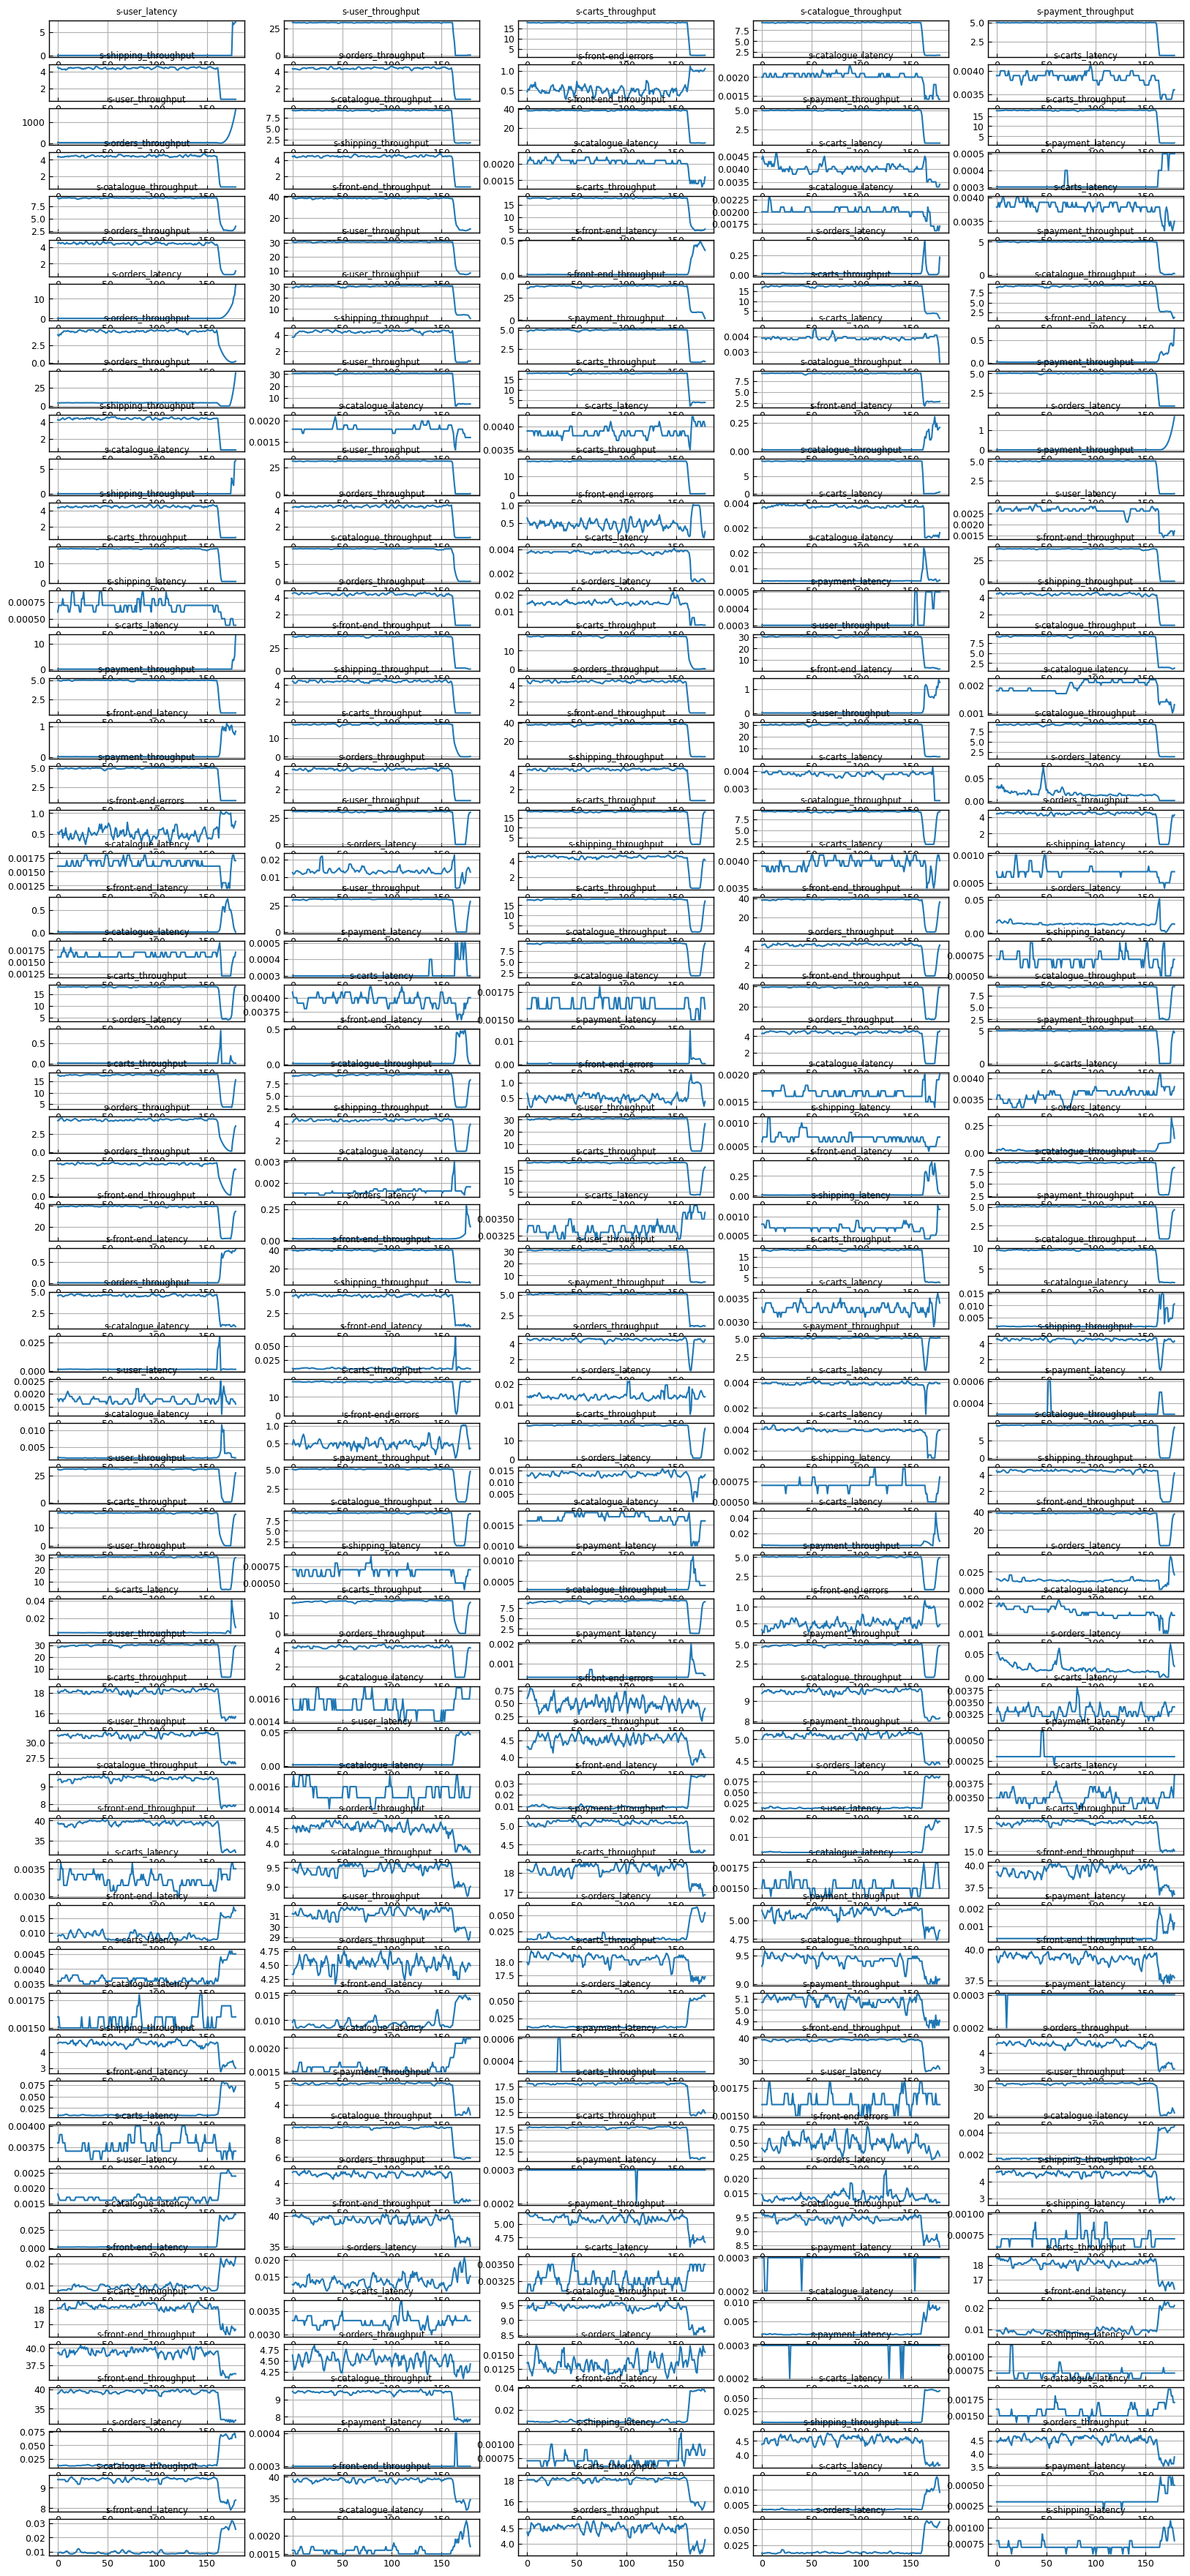

In [19]:
## Visualize
_df = _ranked_df.sort_values(["dataset_id", "target_app", "chaos_type", "chaos_comp", "rank"], ascending=False).groupby(["dataset_id", "target_app", "chaos_type", "chaos_comp"]).head(n=10).set_index(["dataset_id", "target_app", "chaos_type", "chaos_comp"])
fig = plt.figure(figsize=(20, 45))
axs = fig.subplots(nrows=math.ceil(_df.shape[0] / 5), ncols=5)
for ax, row in zip(axs.flatten(), _df.itertuples()):
    ax.plot(row.time_series)
    ax.set_title(row.metric)

In [45]:
_df = _ranked_df.sort_values(["dataset_id", "target_app", "chaos_type", "chaos_comp", "rank"], ascending=False).groupby(["dataset_id", "target_app", "chaos_type", "chaos_comp"]).head(n=10).set_index(["dataset_id", "target_app", "chaos_type", "chaos_comp"])
results = []
for (dataset_id, target_app, chaos_type, chaos_comp), row in _df.iterrows():
    results.append(((dataset_id, target_app, chaos_type, chaos_comp, row.metric, row.time_series.tolist())))
pd.DataFrame(results, columns=["dataset_id", "target_app", "chaos_type", "chaos_comp","metric", "time_series"]).to_json(path_or_buf="../anomaly_metrics_samples.json", index=True)

## Anomaly degree + FluxInfer

In [20]:
MIN_P: float = 0.0001

def score_multiplied_by_anomaly_degree(x: pd.Series) -> np.ndarray:
    P = x["anomaly_degree"]  # anomaly degree (normalize to [0, 1])
    score = x["rank"]
    # return score * (-np.log2(max([P, MIN_P])))
    return score * P

# from sklearn.preprocessing import minmax_scale

# def _minmax_scale(X):
#     # X_ = np.atleast_2d(X)
#     nz = minmax_scale(X, feature_range=(0, 1))
#     # reverse nz
#     return pd.DataFrame(1-nz, X.index)

from tsdr.outlierdetection.residual_integral import residual_integral_max

ranked_df_max_cluster["anomaly_degree"] = ranked_df_max_cluster.apply(lambda x: residual_integral_max(x.time_series, bkp=0)[0], axis=1)
# ranked_df_max_cluster["anomaly_degree"] = ranked_df_max_cluster.groupby(["dataset_id", "target_app", "chaos_type", "chaos_comp"])["anomaly_degree"].apply(_minmax_scale)
ranked_df_max_cluster["anomaly_based_pagerank"] = ranked_df_max_cluster.apply(score_multiplied_by_anomaly_degree, axis=1)

_sorted_results_df = ranked_df_max_cluster.query("not metric.str.startswith('n-')", engine='python').loc[:, ranked_df.columns != "time_series"].dropna(subset=["rank"]).sort_values(["dataset_id", "target_app", "chaos_type", "chaos_comp", "anomaly_based_pagerank"], ascending=False).groupby(["dataset_id", "target_app", "chaos_type", "chaos_comp"])
# with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None):
#     display(_sorted_results_df.head(n=10).set_index(["dataset_id", "target_app", "chaos_type", "chaos_comp"]))

with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None, "display.precision", 2):
    display(
        pd.concat([
            evaluate_ac_of_rc(_sorted_results_df, pk, k=10, granuallity="metric"),
            evaluate_ac_of_rc(_sorted_results_df, pk, k=10, granuallity="container"),
            evaluate_ac_of_rc(_sorted_results_df, pk, k=10, granuallity="service"),
        ], axis=1)
    )

no cause metrics: qknmc, sock-shop, pod-memory-hog, catalogue
no cause metrics: qknmc, sock-shop, pod-memory-hog, orders
no cause metrics: qknmc, sock-shop, pod-memory-hog, payment
no cause metrics: qknmc, sock-shop, pod-network-loss, catalogue
no cause metrics: qknmc, sock-shop, pod-network-loss, payment
no cause metrics: qknmc, sock-shop, pod-network-loss, user-db


AC@K (metric)  AVG@K (metric)  AC@K (container)  AVG@K (container)  \
1            0.09            0.09              0.31               0.31   
2            0.09            0.09              0.66               0.48   
3            0.13            0.10              0.69               0.55   
4            0.13            0.11              0.83               0.62   
5            0.13            0.11              0.86               0.67   
6            0.22            0.13              0.86               0.70   
7            0.26            0.15              0.93               0.73   
8            0.35            0.17              0.97               0.76   
9            0.39            0.20              1.00               0.79   
10           0.39            0.22              1.00               0.81   

    AC@K (service)  AVG@K (service)  
1             0.31             0.31  
2             0.62             0.47  
3             0.76             0.56  
4             0.83             0.63  
5             0.90             0.68  
6             1.00             0.74  
7             1.00             0.77  
8             1.00             0.80  
9             1.00             0.82  
10            1.00             0.84

## WUDG + directed edges based network dependencies + PageRank

In [21]:
_list_of_records = joblib.Parallel(n_jobs=-1)(joblib.delayed(build_wudg_and_pagerank)(record, reduced_df, init_graph_type="nw_call", directed_edge=True) for record, _, _, reduced_df in datasets_fluxrank_max_cluster)
ranked_datasets_directed = sum(_list_of_records, [])  # flatten

ranked_df = pd.DataFrame(ranked_datasets_directed, columns=["dataset_id", "target_app", "chaos_type", "chaos_comp", "metric", "time_series", "rank"])
sorted_results_df_directed = ranked_df.query("not metric.str.startswith('n-')", engine='python').loc[:, ranked_df.columns != "time_series"].dropna(subset=["rank"]).sort_values(["dataset_id", "target_app", "chaos_type", "chaos_comp", "rank"], ascending=False).groupby(["dataset_id", "target_app", "chaos_type", "chaos_comp"])
with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None):
    display(sorted_results_df_directed.head(n=10).set_index(["dataset_id", "target_app", "chaos_type", "chaos_comp"]))
    
with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None, "display.precision", 2):
    display(
        pd.concat([
            evaluate_ac_of_rc(sorted_results_df_directed, pk, k=10, granuallity="metric"),
            evaluate_ac_of_rc(sorted_results_df_directed, pk, k=10, granuallity="container"),
            evaluate_ac_of_rc(sorted_results_df_directed, pk, k=10, granuallity="service"),
        ], axis=1)
    )

metric  \
dataset_id target_app chaos_type       chaos_comp                                                                                   
qknmc      sock-shop  pod-network-loss user-db                                                                 s-front-end_errors   
                                       user-db                                                                     s-user_latency   
                                       user-db                                                                  s-user_throughput   
                                       user-db                                                     c-orders_cpu_cfs_periods_total   
                                       user-db                                                   c-orders_cpu_usage_seconds_total   
                                       user-db                                                  c-orders_cpu_system_seconds_total   
                                       user-db                                                    c-orders_cpu_user_seconds_total   
                                       user-db                                                     c-orders_memory_failures_total   
                                       user-db                                                          c-orders_file_descriptors   
                                       user-db                                                                   c-orders_sockets   
                                       user                                                                s-front-end_throughput   
                                       user                                                                      s-orders_latency   
                                       user                                                                   s-orders_throughput   
                                       user                                                                       c-carts_threads   
                                       user                                                                        c-user_sockets   
                                       user                                                                     c-user_memory_rss   
                                       user                                                             c-user_memory_usage_bytes   
                                       user                                                       c-user_memory_working_set_bytes   
                                       user                                                         c-user_cpu_user_seconds_total   
                                       user                                                        c-user_cpu_usage_seconds_total   
                                       payment                                          c-payment_cpu_cfs_throttled_periods_total   
                                       payment                                          c-payment_cpu_cfs_throttled_seconds_total   
                                       payment                                                                    s-carts_latency   
                                       payment                                                                 s-carts_throughput   
                                       payment                                                                 c-carts_memory_rss   
                                       payment                                                         c-carts_memory_usage_bytes   
                                       payment                                                   c-carts_memory_working_set_bytes   
                                       payment              m-carts_java_lang_GarbageCollector_LastGcInfo_memoryUsageAfterGc_used   
                                       payment                           m-carts_java_lang_OperatingSystem_FreePhysicalMemorySize   


no cause metrics: qknmc, sock-shop, pod-memory-hog, catalogue
no cause metrics: qknmc, sock-shop, pod-memory-hog, orders
no cause metrics: qknmc, sock-shop, pod-memory-hog, payment
no cause metrics: qknmc, sock-shop, pod-network-loss, catalogue
no cause metrics: qknmc, sock-shop, pod-network-loss, payment
no cause metrics: qknmc, sock-shop, pod-network-loss, user-db


AC@K (metric)  AVG@K (metric)  AC@K (container)  AVG@K (container)  \
1            0.00            0.00              0.10               0.10   
2            0.04            0.02              0.31               0.21   
3            0.17            0.07              0.48               0.30   
4            0.17            0.10              0.72               0.41   
5            0.17            0.11              0.79               0.48   
6            0.17            0.12              0.83               0.54   
7            0.22            0.14              0.83               0.58   
8            0.30            0.16              0.93               0.62   
9            0.35            0.18              0.97               0.66   
10           0.39            0.20              1.00               0.70   

    AC@K (service)  AVG@K (service)  
1             0.10             0.10  
2             0.34             0.22  
3             0.66             0.37  
4             0.86             0.49  
5             0.93             0.58  
6             0.93             0.64  
7             1.00             0.69  
8             1.00             0.73  
9             1.00             0.76  
10            1.00             0.78

## WUDG Personalized PageRank 

In [22]:
import joblib

_list_of_records = joblib.Parallel(n_jobs=-1)(joblib.delayed(build_wudg_and_pagerank)(record, reduced_df, init_graph_type="nw_call", citest="fisher-z", directed_edge=False, personalized=True) for record, _, anomalous_df, reduced_df in datasets_fluxrank_max_cluster)
ranked_datasets = sum(_list_of_records, [])  # flatten

ranked_df_max_cluster = pd.DataFrame(ranked_datasets, columns=["dataset_id", "target_app", "chaos_type", "chaos_comp", "metric", "time_series", "rank"])
sorted_results_df = ranked_df_max_cluster.query("not metric.str.startswith('n-')", engine='python').loc[:, ranked_df_max_cluster.columns != "time_series"].dropna(subset=["rank"]).sort_values(["dataset_id", "target_app", "chaos_type", "chaos_comp", "rank"], ascending=False).groupby(["dataset_id", "target_app", "chaos_type", "chaos_comp"])
with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None):
    display(sorted_results_df.head(n=10).set_index(["dataset_id", "target_app", "chaos_type", "chaos_comp"]))

metric  \
dataset_id target_app chaos_type       chaos_comp                                                                                          
qknmc      sock-shop  pod-network-loss user-db                                                                        s-front-end_errors   
                                       user-db                                                                       s-orders_throughput   
                                       user-db                                                                            s-user_latency   
                                       user-db                                                                          s-orders_latency   
                                       user-db                                                             m-orders_threads_totalStarted   
                                       user-db                                      m-orders_java_lang_Threading_TotalStartedThreadCount   
                                       user-db                                            m-orders_Tomcat_RequestProcessor_bytesReceived   
                                       user-db                                                      m-orders_Tomcat_Servlet_requestCount   
                                       user-db                                             m-orders_Tomcat_RequestProcessor_requestCount   
                                       user-db                                                m-orders_Tomcat_RequestProcessor_bytesSent   
                                       user                                                                       s-front-end_throughput   
                                       user                                                                             s-orders_latency   
                                       user                                                                          s-orders_throughput   
                                       user                                                                            s-user_throughput   
                                       user                                                                              c-carts_threads   
                                       user                                                                               s-user_latency   
                                       user                                                                            c-user_memory_rss   
                                       user                                                                    c-user_memory_usage_bytes   
                                       user                                                              c-user_memory_working_set_bytes   
                                       user                                                                               c-user_threads   
                                       payment                                                 c-payment_cpu_cfs_throttled_periods_total   
                                       payment                                                 c-payment_cpu_cfs_throttled_seconds_total   
                                       payment                                                                           s-carts_latency   
                                       payment                                                                        s-carts_throughput   
                                       payment                                                                        c-carts_memory_rss   
                                       payment                                                                         s-payment_latency   
                                       payment                                                                c-carts_memory_usage_bytes   
                                       payment                        

In [23]:
with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None, "display.precision", 2):
    display(
        pd.concat([
            evaluate_ac_of_rc(sorted_results_df, pk, k=10, granuallity="metric"),
            evaluate_ac_of_rc(sorted_results_df, pk, k=10, granuallity="container"),
            evaluate_ac_of_rc(sorted_results_df, pk, k=10, granuallity="service"),
        ], axis=1)
    )

no cause metrics: qknmc, sock-shop, pod-memory-hog, catalogue
no cause metrics: qknmc, sock-shop, pod-memory-hog, orders
no cause metrics: qknmc, sock-shop, pod-memory-hog, payment
no cause metrics: qknmc, sock-shop, pod-network-loss, catalogue
no cause metrics: qknmc, sock-shop, pod-network-loss, payment
no cause metrics: qknmc, sock-shop, pod-network-loss, user-db


AC@K (metric)  AVG@K (metric)  AC@K (container)  AVG@K (container)  \
1            0.00            0.00              0.21               0.21   
2            0.04            0.02              0.45               0.33   
3            0.13            0.06              0.66               0.44   
4            0.13            0.08              0.72               0.51   
5            0.13            0.09              0.72               0.55   
6            0.22            0.11              0.83               0.60   
7            0.22            0.12              0.93               0.65   
8            0.30            0.15              0.93               0.68   
9            0.35            0.17              0.97               0.71   
10           0.39            0.19              1.00               0.74   

    AC@K (service)  AVG@K (service)  
1             0.21             0.21  
2             0.41             0.31  
3             0.72             0.45  
4             0.86             0.55  
5             0.93             0.63  
6             1.00             0.69  
7             1.00             0.73  
8             1.00             0.77  
9             1.00             0.79  
10            1.00             0.81